# **SUBREDDIT RECOMMENDATION WITH MATRIX FACTORIZATION**

---
PSTAT 231 FINAL PROJECT

Jiashu Huang

Dec 6th, 2022


# **1. Introduction**

A considerable part of this project, such as the logistic of some code, is inspired by the course https://www.udemy.com/course/recommender-systems/.

## **1.1 What is Reddit**

Reddit is a network of communities where people can dive into their interests, hobbies, and passions. Each community is generally called a subreddit channel. Registered users submit content to the site, such as links, text posts, images, and videos, which other members then vote up or down. 

## **1.2 Why Recommendation**

To date, there are about 3 million subreddit channels. It is easy to get lost in the vast space of different channels but hard to find the right ones. An efficient recommendation model would help Reddit users explore their interests, find like-minded people, and be involved in diverse communities.

## **1.3 Project Objective**

Due to the limitation of computational power, this project aims to build a relatively rudimentary model that based its results on the most popular 10,000 subreddit channels. The model should be able to provide a top 10 channel list based on the previous browsing history. 

# **2. Data Preprocessing**



## **2.1 Data Collection**

The data used in this project is collected on the website https://files.pushshift.io/reddit/comments/. Due to the limitation of computational power, only data from the first day of October 2021 was collected. The data size was further reduced using random sampling.


## **2.2 Data Cleaning**

Recommendation systems are normally based on users' ratings of different products. However, in the case of Reddit, users do not directly rate any subreddit channels. The only data we have access to (the data we collected above) is that of the individual comments. Therefore, we have to derive a 'rating' from the attributes of the comment data. The comment data is stored in the form of


[***author***, ***net_upvotes***, ***subreddit***, ***text***].


Initially, the data covers over 1,300,000 different authors, over 60,000 different subreddit channels, and over 5,000,000 comments.

However, since recommendation systems utilize the similarities between users to formulate recommendations, users that comment only once or twice and channels that have only been commented on once or twice are useless. Thus, we further reduce the sample size by limiting the minimum number of user comments to 3 and withholding only the top 10,000 subreddit channels. Then we perform a random sampling procedure again, so there are only 10,000 different authors.

The finalized dataset has only 10,000 different authors and 10,000 subreddit channels, but still over 360,000 comments.

## **2.3 Dictionary Conversion**

The final step of data preprocessing is to convert data frames to dictionaries.

But WHY do we need to do this?

During the training process, we need to constantly access the element in the data frame. Therefore, the time complexity of this process would be $O(n^2)$. With the size of 10,000 * 10,000 (plus if we want to apply it to larger data), the computation could be really slow. However, we only have 360,000 comments instead of 100,000,000. Thus, by creating a dictionary in the form of 

$\text{{(user1, channel1): rating, (user2, channel5): rating, ...}}$

we can reduce the time complexity to $O(Z)$, where Z is the number of comments.

Before we do the conversion, we first split the data into three sets: the training set, the validation set, and the testing set, with the proportion of 6 : 2 : 2.

For the training dataset, other than the dictionary shown above, we also need two additional dictionaries, one for checking which channels each user has commented on in the form of 

$\text{{user1: [channel1, channel2, channel3, ...], user2: [channel101],...}}$

the other one checking which users have commented on each Reddit channel in the form of 

$\text{{channel1: [user1, user2, user3, ...], channel2: [user4, user5], ...}}$. 

In total, we have five dictionaries, three user-channel-to-rating ones for each dataset, and two additional ones for the training set only.

# **3. Exploratory Data Analysis**

First, import all libraries we need.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
import seaborn as sns
import math
from sortedcontainers import SortedList
from sklearn.decomposition import PCA
from datetime import datetime

Load the data in data frame form for EDA. Texts are already transformed to text_length for convenience.

In [4]:
df = pd.read_csv("Data/small.csv")
df.drop(columns = ["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"], inplace = True)

In [ ]:
df.head()

,author,subreddit,score,text_length,user_id,channel_id
0,ThatRookieGuy80,AskMen,7.0,10,0,0
1,Gr000vy,backpain,5.0,13,1,1
2,623-252-2424,PublicFreakout,2.0,2,2,2
3,Soviet-Biscuit,mildlyinfuriating,2.0,5,3,3
4,judyclimbs,MadeMeSmile,8.0,37,4,4


Let's take a look at the distribution of text lengths and scores.

In [ ]:
import random
random_sample = random.choices(range(df.shape[0]), k=1000)
EDA = df.loc[random_sample, ["score", "text_length"]]

Scores are mostly from 0 to 10, peaking at score = 0. It is reasonable because most comments receive zero votes. Text lengths have a right-skewed distribution.

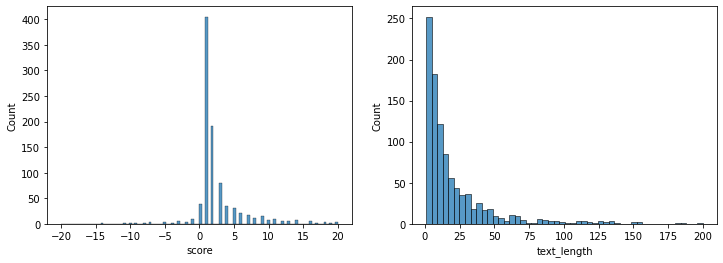

In [ ]:
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1, 2, 1)
sns.histplot(EDA.score, binrange=[-20,20])
plt.subplot(1, 2, 2)
sns.histplot(EDA.text_length, binrange=[1,200])

Now let's look at the relationship between them.

In [ ]:
print("Correlation Coefficient: ", EDA.score.corr(EDA.text_length))

Correlation Coefficient:  -0.012127856028413023


(-100.0, 200.0)

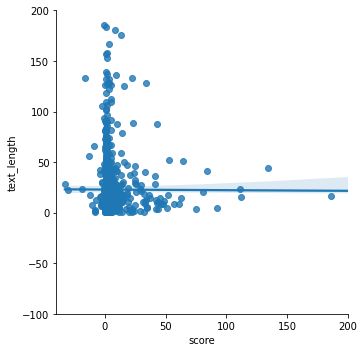

In [ ]:
sns.lmplot(x = "score", y = "text_length", data = EDA)
plt.xlim(-40, 200)
plt.ylim(-100, 200)

There isn't a strong correlation between them, which is counterintuitive. The amount of words you put in doesn't affect how many upvotes you will get. Thus, it is not reasonable to perform PCA here.

Instead, we will directly use "score" as the "rating" output variable. The more upvotes one gets in the subreddit channel, the more likely one fits in this channel. The last thing we need to do here is normalize the "score" data.

# **4. Experiments**

For a comparative analysis, we divide this section into two parts. The first part uses a non-parametric method that has no trainable parameters, called user-user collaborative filtering. The second part uses matrix factorization and incorporates machine learning concepts to perform the recommendation. In the next section, we will compare and evaluate the results of both of them.

## **4.1 User-user collaborative filtering.**

One reasonable way to recommend is to find similar users based on your browsing history and recommend the channels similar users love.

Without consideration for similarities, the predicted rating of channel j for user i would just be
\begin{align}
R(i, j) = \frac{\sum_{i' \in CHANNEL_j}R(i', j)}{|CHANNEL_j|}
\end{align}
the average rating of this channel.

Instead, we added a weight for each $R(i', j)$. The weight is the cosine similarity between user $i$ and $i'$.

For example, given 
```
User  | PublicFreakout | MadeMeSmile | AskReddit | TedLasso 
------|----------------|-------------|-----------|----------
Tom   | 0              | 1           | 2         | 3
Jack  | 1              | 3           | 5         | 7
Jason | 2              | 4           | 6         | 8
Brown | 4              | 3           | 2         | 1
```
The cosine similarity between Jason and Jack would be 0.996. In contrast, the cosine similarity between Jack and Brown is 0.597. By incorporating cosine similarities, Brown's ratings now matter less than Jason's ratings for Jack's recommendations. 

The new formula is 
\begin{align}
R(i, j) = \frac{\sum_{i' \in CHANNEL_j}W(i, i')R(i', j)}{\sum_{i' \in CHANNEL_j}W(i, i')}
\end{align}
where $W(i, i')$ is the cosine similarity between user $i$ and $i'$.

However, there is still a problem. Even two similar users could be very different. For example, one may be popular and get upvotes all the time, while the other may only get upvotes from time to time. Thus, we want to use comparative ratings rather than raw ratings. We do so by calculating the deviations.

Instead of $R(i', j)$, we use $R(i', j) - \overline{R(i')}$ to denote the comparative ratings. The final recommendation formula we get is
\begin{align}
R(i, j) = \frac{\sum_{i' \in CHANNEL_j}W(i, i')(R(i', j) - \overline{R(i')})}{\sum_{i' \in CHANNEL_j}W(i, i')}
\end{align}

Additionally, we only consider the first 25 similar users' ratings. The 25 neighbor correlation weights of each user would be stored in a dictionary.

Now is the implementation part.

Load in the five dictionaries.

In [5]:
with open("Data/user_to_channel.json", 'rb') as f:
    user_to_channel = pickle.load(f)
with open("Data/channel_to_user.json", 'rb') as f:
    channel_to_user = pickle.load(f)
with open("Data/to_rating.json", 'rb') as f:
    to_rating = pickle.load(f)
with open("Data/to_rating_test.json", 'rb') as f:
    to_rating_test = pickle.load(f)
with open("Data/to_rating_val.json", 'rb') as f:
    to_rating_val = pickle.load(f)

In [6]:
I = len(user_to_channel.keys())
j1 = np.max(list(channel_to_user.keys()))
j2 = np.max(pd.Series([m for (u,m), k in to_rating_test.items()]).unique())
J = max(j1, j2)
print("number of users: ", I)
print("number of channels: ", J)

number of users:  9835
number of channels:  9999


Let's construct the neighbors dictionary for similarity weights.

In [ ]:
count = 0
# number of maximum neighbors (similar users)
n = 25
# Have to have more than 2 subreddits in common to be considered neighbors.
limit = 2
neighbors = {}
averages = {}
deviations = []
for i in user_to_channel.keys():
    # All ratings by user i
    channel_i = user_to_channel[i]
    channel_i_set = set(channel_i)
    
    # Compute the comparative rating, average rating, norm of ratings for user i
    channel_to_rating_i = {channel: to_rating[(i, channel)] for channel in channel_i}
    average_i = np.mean(list(channel_to_rating_i.values()))
    rating_to_dev = {channel: rating - average_i for channel, rating in channel_to_rating_i.items()}
    dev_i = np.array(list(rating_to_dev.values()))
    std_i = np.sqrt(dev_i[0].dot(dev_i[0]))
    
    averages[i]=average_i
    deviations.append(rating_to_dev)
    
    # Prepare the store the similarities
    sl = SortedList()
    for j in user_to_channel.keys():
        # Loop through every other user
        if j != i:
            channel_j = user_to_channel[j]
            channel_j_set = set(channel_j)
            # number of subreddit channels in common
            common = (channel_i_set & channel_j_set)
            # Have to have more than 'limit' amount of channels
            if len(common) >= limit:
                # Compute the comparative rating, average rating, and norm of ratings for user i'.
                channel_to_rating_j = {channel: to_rating[(j, channel)] for channel in channel_j}
                average_j = np.mean(list(channel_to_rating_j.values()))
                rating_to_dev_j = {channel: rating - average_j for channel, rating in channel_to_rating_j.items()}
                dev_j = np.array(list(rating_to_dev_j.values()))
                std_j = np.sqrt(dev_j[0].dot(dev_j[0]))
                
                # Calculate the similarity weights (correlation coefficient) between i and i'.
                nom = sum(rating_to_dev[m] * rating_to_dev_j[m] for m in common)
                denom = std_i * std_j
                w_ij = nom/denom
                
                # Store the weights into a sorted list
                sl.add((-w_ij, j))
                # Only keep n top neightbors.
                if len(sl) > n:
                    del sl[-1]

    neighbors[i] = (sl)
    count += 1


By the formula we derived, we can get the prediction using the neighbor dictionary.

In [ ]:
# Prediction using the neightbor dictionary
def predict(i, m):
    numerator = 0
    denominator = 0
    for neg_w, j in neighbors[i]:
        # if i exists, then calculate
        try:
            # the formula we derived
            numerator += -neg_w * deviations[j][m]
            denominator += abs(neg_w)
        # otherwise pass
        except:
            pass
    if denominator == 0:
        prediction = averages[i]
    else:
        prediction = averages[i] + (numerator/denominator)
    if isinstance(prediction, np.ndarray):
        prediction = prediction.tolist()[0]
    return prediction

# Training set predictions
train_prediction = []
train_target = []
for (i,m), target in to_rating.items():
    prediction = predict(i, m)
    train_prediction.append(prediction)
    train_target.append(target[0])

# Testing set predictions
test_prediction = []
test_target = []
for (i,m), target in to_rating_test.items():
    if i in neighbors.keys():
        prediction = predict(i, m)
        test_prediction.append(prediction)
        test_target.append(target[0])

For now, we have pretty much finished building the user-user recommendation system. The results are stored in *train_prediction* and *test_prediction*. We will evaluate them after implementing the next method, matrix factorization.

## 4.2 Matrix Factorization

### **4.2.1 Intuition**

Recall the user-item matrix in 4.1. It is a $N \times M$ sparse matrix with only Z existing data. We will call the matrix $\Omega$.


```
User    | Channel_1 | Channel_2 | ... | Channel_m 
--------|-----------|-----------|-----|----------
user_1  | \         | 1         | ... | \
user_2  | 1         | 3         | ... | 7
...     | ...       | ...       | ... | ...
user_n  | \         | \         | ... | 1
```
According to singular value decomposition theory, a $N \times M$ real or complex matrix factorized and expressed as the product of three matrices $U \times \Sigma \times V^{T}$, where $U$ is a $N \times N$ matrix, $\Sigma$ is a $N \times M$ matrix, and $V$ is a $M \times M$ matrix.

Additionally, we can truncate three matrices to make them smaller by choosing a value $K$ that is less than $N$ and $M$. Now, $U$ has the shape of $N \times K$, $\Sigma$ has the shape of $K \times K$, and $V$ has the shape of $K \times M$. But still, we get an approximately similar matrix $\hat{\Omega}$ by multiplying the three truncated matrices.

In matrix factorization, we only use 2 instead of 3 matrices to estimate $\Omega$. Our estimation formula is written as 
\begin{align}
\hat{\Omega} = W \times U^{T}
\end{align}

In this project, $N$ and $M$ are 10,000, while $Z$ is around 360,000, which means $1-\frac{360,000}{100,000,000} = 99.7\%$ of this matrix is empty. Since we only feed existing data into the model, $W$ and $U$ will only learn to effectively predict existing data ($0.3\%$).

However, we don't know whether they will predict the rest of the matrix (99.7%) well. Plus, there's no way to evaluate the estimates since we don't know the true data.

Thus, we split the existing data into training and testing sets. In the training section, we feed into the model around $220,000$ data. Then we use the model to predict $72,000$ data in the testing set (the rest of the data is in the validation set). The evaluation will be based on the testing dataset.

To predict one particular rating, we do not need to perform the entire matrix multiplication. For example, to get the predicted rating of user i on channel j, we could use the formula
\begin{align} 
\hat{\Omega}_{i, j} = W_{i} \times U_{j}^{T}
\end{align}
based on the rules of matrix multiplication.

This way of looking at it helps us to interpret the matrix factorization process. Let's take users "TOM" & "JACK" and channels "TedLasso" & "SAT," for instance. Suppose the $W_{i}$ for "TOM" and "JACK" is
```
TOM  | 4     | 7     | 1     | 2     | 1
JACK | 1     | 1     | 2     | 9     | 4
```
$U_{j}$ for "TedLasso" and "SAT" is 
```
TedLasso | 1     | 10     | 9     | 2     | 0
SAT      | 1     | 1      | 1     | 8     | 2
```

Notice that if we want to predict the rating of one user on one channel, we calculate the product of the same columns and take the sum of them. This process is very similar to calculating cosine similarity. Thus, we can interpret the columns of $W$ and $U$ as arbitrary categories that the program gradually learns. 

For example, the second category could be a "SPORT" characteristic. Tom likes sports, so he has a 7. Ted Lasso is a sports show, so it has a 10. Jack may be a rising senior and care about studying more, so he has a 1. Similarly, SAT has nothing to do with sports, so it gets a 1. In this way, when predicting the ratings for TedLasso, Tom would gain $(7)\times(10)$ predicted ratings based solely on the second category, and Jack only gains $(1)\times(10)$ predicted ratings. In contrast, when we predict the ratings for SAT, the second category doesn't contribute greatly to either of them.

The amount of categories, $K$, is a controllable variable. The larger K is, the more complicated the algorithm and the more likely the model will perform on complex scenarios. Notice, unlike what we just assume, the categories trained by the model don't have an explicitly interpretable name such as "SPORT." Instead, the categories are "LATENT."

Now let's initialize these matrices.

In [159]:
K = 100
W = np.random.randn(10000, K)
P = np.zeros(10000)
U = np.random.randn(10000, K)
Q = np.zeros(10000)
mu = np.mean(list(to_rating.values()))

Note that except $K, W,$ and $U$, there are more variables $P$, $Q$, and $\mu$. These are bias terms that help make our predictions more accurate.

Recall we used
\begin{align} 
\hat{\Omega}_{i, j} = W_{i} \times U_{j}^{T}
\end{align}
to predict ratings.

However, there's a problem with our previous method. Even if two channels have the exact same characteristics and have very similar categorical ratings, their quality could be very different. Similarly, similar users could have different devotion to using Reddit as well. Thus, we introduce $P$ and $Q$ as bias terms for users and channels. They are trainable as well.

$\mu$ is the global average rating that helps us center our predictions. It doesn't need to be trained.

The final prediction formula becomes
\begin{align} 
\hat{\Omega}_{i, j} = W_{i} \times U_{j}^{T} + P_{i} + Q_{j} + \mu
\end{align}

### **4.2.2 Loss function and Optimizer**
The loss function and optimizer we use are simple: MEAN SQUARE ERROR & GRADIENT DESCENT. Let's first define our loss function. The for loop loops through every existing data in d (training set & testing set would be passed into it).


In [158]:
def get_loss(d):
    N = float(len(d))
    Error = 0
    for k, r in d.items():
        i, j = k
        p = W[i].dot(U[j]) + P[i] + Q[j] + mu
        Error += (p-r)*(p-r)
    return Error/N

Now, all we need to do is to derive the update rule by calculating the derivative of our loss function with respect to each parameter.

Our loss function is
\begin{align}
J &= \sum_{Z}(\Omega_{i, j} - \hat{\Omega}_{i_j})^{2} \\
&= \sum_{Z}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - Q_{j} - \mu)^{2}
\end{align}

Let's start with $W$
\begin{align}
\frac{\partial J}{\partial W_{i}} &= \frac{\partial}{\partial W_{i}}\sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - Q_{j} - \mu)^{2} \\
&= 2 \sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - Q_{j} - \mu)(-U_{j})    & \text{##Chain rule}\\
&=0\\
\end{align}
So
$$\sum_{Z_i}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(U_{j}) = \sum_{Z_i}(W_{i} \times U_{j}^{T})(U_{j})$$
Since $W_{i}$ is a constant for all element in $Z_{i}$, we get
$$\sum_{Z_i}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(U_{j}) = W_{i}\sum_{Z_i}(U_{j}^{T})(U_{j})$$
$$W_{i} = [\sum_{Z_i}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(U_{j})](\sum_{Z_i}U_{j}^{T}U_{j})^{-1}$$
The updating rule for $U$ can be derived in the exact same way as $W$.
$$U_{J} = [\sum_{Z_j}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(W_{i})](\sum_{Z_j}W_{i}^{T}W_{i})^{-1}$$
The derivations for P and Q are similar.
\begin{align}
\frac{\partial J}{\partial P_{i}} &= \frac{\partial}{\partial P_{i}}\sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - Q_{j} - \mu)^{2} \\
&= 2 \sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - Q_{j} - \mu)(-1)\\
&=0\\
\sum_{Z_{i}}(&\Omega_{i, j} - W_{i} \times U_{j}^{T} - Q_{j} - \mu) = \sum_{Z_{i}}P_{i}\\
P_{i} = &\frac{1}{|Z_{i}|}\sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - Q_{j} - \mu)\\
\text{and}\\
Q_{j} = &\frac{1}{|Z_{j}|}\sum_{Z_{j}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - \mu)
\end{align}


### **4.2.3 Regularization**

Note that the user-item matrix we use to train the model is really sparse. Thus, it may be really easy to overfit. We add a regularization term (just like ridge and lasso) to the loss function in response to this problem. Now 
$$J = \sum_{Z}(\Omega_{i, j} - \hat{\Omega}_{i_j})^{2} + \lambda(||W||^2 + ||U||^2 + ||P||^2 + ||Q||^2)$$
The update rule for each parameter changes a little bit.
\begin{align}
\left\{
\begin{array}{C}
W_{i} = [\sum_{Z_i}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(U_{j})](\sum_{Z_i}U_{j}^{T}U_{j} + \lambda I)^{-1}\\
U_{j} = [\sum_{Z_j}(\Omega_{i, j} - P_{i} - Q_{j} - \mu)(W_{i})](\sum_{Z_j}W_{i}^{T}W_{i} + \lambda I)^{-1}\\
P_{i} = \frac{1}{|Z_{i}|+\lambda}\sum_{Z_{i}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - Q_{j} - \mu)\\
Q_{j} = \frac{1}{|Z_{j}|+\lambda}\sum_{Z_{j}}(\Omega_{i, j} - W_{i} \times U_{j}^{T} - P_{i} - \mu)
\end{array}
\right.
\end{align}
Additionally, we use EARLY STOPPING as another regularization method during training. We terminate the training if the validation loss increases for two consecutive epochs.

### **4.2.4 Training**
In each epoch, we update 4 parameters one by one. This method is called alternative least squares and has proven effective in many cases.

The general procedure we perform for each epoch is


1.   Loop through all user
2.   Update $W_{i}$ and $P_{i}$ for each user $i$
3.   Loop through all channels
4.   Update $U_{j}$ and $Q_{j}$ for each channel $j$
5.   Calculate train/validation loss for this epoch
6.   Terminate training if validation loss increases for two consecutive epochs.

The maximum epochs we allow is 20.

There are two parameters we need to tune in the training process. The value of the size of the latent dimension, $K$, and the value of the regularization term $\lambda$.

Due to the lack of computational power, we tune these two parameters one by one. First, we investigate the relationship between $\lambda$ and the model performance.

In [ ]:
train_vs_reg = []
val_vs_reg = []
test_vs_reg = []
for i in [1, 3, 10, 30, 100, 300, 1000, 3000, 10000]:
    epochs = 20
    reg = i
    train_losses = []
    val_losses = []
    train_losses.append(get_loss(to_rating))
    val_losses.append(get_loss(to_rating_val))
    stop = 0
    for epoch in range(epochs):
        print("epoch:", epoch)
        epoch_start = datetime.now()
        
        t0 = datetime.now()
        for i in user_to_channel.keys():
            matrix = np.eye(K) * reg
            vector = np.zeros(K)
            
            pi = 0
            for j in user_to_channel[i]:
                r = to_rating[(i, j)]
                matrix += np.outer(U[j], U[j])
                vector += (r - P[i] - Q[i] - mu) * U[j]
                pi += (r - W[i].dot(U[j]) - Q[j] - mu)
            
            W[i] = np.linalg.solve(matrix, vector)
            P[i] = pi / (len(user_to_channel[i]) + reg)
        
        for j in channel_to_user.keys():
            matrix = np.eye(K) * reg
            vector = np.zeros(K)
            
            Qj = 0
            try:
                for i in channel_to_user[j]:
                    r = to_rating[(i, j)]
                    matrix += np.outer(W[i], W[i])
                    vector += (r - P[i] - Q[j] - mu) * W[i]
                    Qj += (r - W[i].dot(U[j]) - P[i] - mu)
                
                U[j] = np.linalg.solve(matrix, vector)
                Q[j] = Qj / (len(channel_to_user[j]) + reg)
                
            except KeyError:
                pass
        
        train_losses.append(get_loss(to_rating))
        val_losses.append(get_loss(to_rating_val))
        print("time spent:", datetime.now() - t0)
        print("train loss:", train_losses[-1])
        print("validation loss:", val_losses[-1])
        print(get_loss(to_rating_test))
        if val_losses[-1] > val_losses[-2]:
            stop += 1
        else:
            stop = 0
        if stop == 2:
            break
    train_vs_reg.append(train_losses)
    val_vs_reg.append(val_losses)
    K = 100
    W = np.random.randn(10000, K)
    P = np.zeros(10000)
    U = np.random.randn(10000, K)
    Q = np.zeros(10000)
    mu = np.mean(list(to_rating.values()))

Text(0.5, 0, 'Regularization term in log scale')

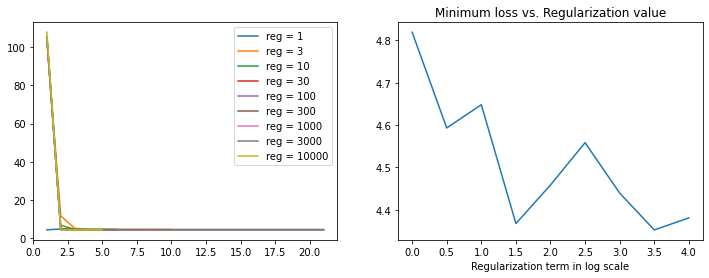

In [40]:
losses = [i[-1] for i in val_vs_reg[0:9]]
plt.rcParams['figure.figsize'] = [12,4]
plt.subplot(1, 2, 1)
plt.plot(range(1, len(val_vs_reg[0])+1), val_vs_reg[0], label='reg = 1')
plt.plot(range(1, len(val_vs_reg[1])+1), val_vs_reg[1], label='reg = 3')
plt.plot(range(1, len(val_vs_reg[2])+1), val_vs_reg[2], label='reg = 10')
plt.plot(range(1, len(val_vs_reg[3])+1), val_vs_reg[3], label='reg = 30')
plt.plot(range(1, len(val_vs_reg[4])+1), val_vs_reg[4], label='reg = 100')
plt.plot(range(1, len(val_vs_reg[5])+1), val_vs_reg[5], label='reg = 300')
plt.plot(range(1, len(val_vs_reg[6])+1), val_vs_reg[6], label='reg = 1000')
plt.plot(range(1, len(val_vs_reg[7])+1), val_vs_reg[7], label='reg = 3000')
plt.plot(range(1, len(val_vs_reg[8])+1), val_vs_reg[8], label='reg = 10000')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], losses[0:9])
plt.title("Minimum loss vs. Regularization value")
plt.xlabel("Regularization term in log scale")

The first plot graphs the whole training process, while the second only records the minimum loss for each regularization value.

The up-and-downs in the graph indicate that how we initialize $W$ and $U$ is crucial to the model performance. The pattern we see now is generally correct but not accurate enough. However, the computational power doesn't allow for performing cross-validation. 

Thus, we train the model three times each for $\lambda$ value of $10$, $30$, $100$, $300$, $1000$, and $3000$, and take the average of them for better accuracy.

In [ ]:
AAAA = []
BBBB = []
for i in [10, 30, 100, 300, 1000, 3000]:
    AAA = []
    BBB = []
    for k in [1, 2, 3]:
      epochs = 20
      reg = i
      train_losses = []
      val_losses = []
      train_losses.append(get_loss(to_rating))
      val_losses.append(get_loss(to_rating_val))
      stop = 0
      for epoch in range(epochs):
          print("epoch:", epoch)
          epoch_start = datetime.now()
          
          t0 = datetime.now()
          for i in user_to_channel.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              pi = 0
              for j in user_to_channel[i]:
                  r = to_rating[(i, j)]
                  matrix += np.outer(U[j], U[j])
                  vector += (r - P[i] - Q[i] - mu) * U[j]
                  pi += (r - W[i].dot(U[j]) - Q[j] - mu)
              
              W[i] = np.linalg.solve(matrix, vector)
              P[i] = pi / (len(user_to_channel[i]) + reg)
          
          for j in channel_to_user.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              Qj = 0
              try:
                  for i in channel_to_user[j]:
                      r = to_rating[(i, j)]
                      matrix += np.outer(W[i], W[i])
                      vector += (r - P[i] - Q[j] - mu) * W[i]
                      Qj += (r - W[i].dot(U[j]) - P[i] - mu)
                  
                  U[j] = np.linalg.solve(matrix, vector)
                  Q[j] = Qj / (len(channel_to_user[j]) + reg)
                  
              except KeyError:
                  pass
          
          train_losses.append(get_loss(to_rating))
          val_losses.append(get_loss(to_rating_val))
          print("time spent:", datetime.now() - t0)
          print("train loss:", train_losses[-1])
          print("validation loss:", val_losses[-1])
          if val_losses[-1] > val_losses[-2]:
              stop += 1
          else:
              stop = 0
          if stop == 2:
              break
      AAA.append(train_losses[-1])
      BBB.append(val_losses[-1])
      K = 100
      W = np.random.randn(10000, K)
      P = np.zeros(10000)
      U = np.random.randn(10000, K)
      Q = np.zeros(10000)
      mu = np.mean(list(to_rating.values()))
    AAAA.append(AAA)
    BBBB.append(BBB)

In [49]:
losses[2] = np.array(BBBB[0]).mean()
losses[3] = np.array(BBBB[1]).mean()
losses[4] = np.array(BBBB[2]).mean()
losses[5] = np.array(BBBB[3]).mean()
losses[6] = np.array(BBBB[4]).mean()
losses[7] = np.array(BBBB[5]).mean()

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 0, 'Regularization term in log scale')

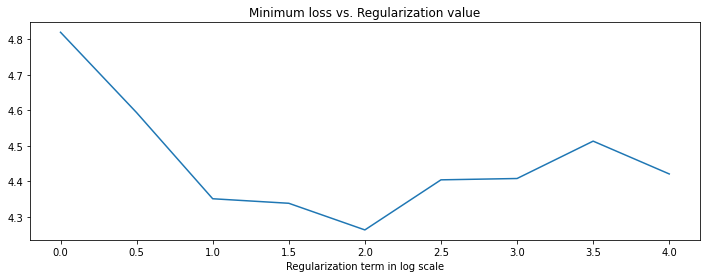

In [58]:
plt.plot([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], losses[0:9])
plt.title("Minimum loss vs. Regularization value")
plt.xlabel("Regularization term in log scale")

The graph now is a lot smoother. We choose $\lambda = 100$ as our best parameter. Now let's tune the size of the latent space.

The results are very unstable if we only train once for each $K$. We do it again by lowering the maximum epochs but increasing the sample size (30) for each $K$ to decrease the variance.

In [ ]:
AAAA = []
BBBB = []

In [ ]:
for p in [10, 30, 50, 70, 90]:
    AAA = []
    BBB = []
    for k in range(30):
      K = p
      W = np.random.randn(10000, K)
      P = np.zeros(10000)
      U = np.random.randn(10000, K)
      Q = np.zeros(10000)
      mu = np.mean(list(to_rating.values()))
      epochs = 3
      reg = 100
      train_losses = []
      val_losses = []
      train_losses.append(get_loss(to_rating))
      val_losses.append(get_loss(to_rating_val))
      stop = 0
      for epoch in range(epochs):
          print("epoch:", epoch)
          epoch_start = datetime.now()
          
          t0 = datetime.now()
          for i in user_to_channel.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              pi = 0
              for j in user_to_channel[i]:
                  r = to_rating[(i, j)]
                  matrix += np.outer(U[j], U[j])
                  vector += (r - P[i] - Q[i] - mu) * U[j]
                  pi += (r - W[i].dot(U[j]) - Q[j] - mu)
              
              W[i] = np.linalg.solve(matrix, vector)
              P[i] = pi / (len(user_to_channel[i]) + reg)
          
          for j in channel_to_user.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              Qj = 0
              try:
                  for i in channel_to_user[j]:
                      r = to_rating[(i, j)]
                      matrix += np.outer(W[i], W[i])
                      vector += (r - P[i] - Q[j] - mu) * W[i]
                      Qj += (r - W[i].dot(U[j]) - P[i] - mu)
                  
                  U[j] = np.linalg.solve(matrix, vector)
                  Q[j] = Qj / (len(channel_to_user[j]) + reg)
                  
              except KeyError:
                  pass
          
          train_losses.append(get_loss(to_rating))
          val_losses.append(get_loss(to_rating_val))
          print("time spent:", datetime.now() - t0)
          print("train loss:", train_losses[-1])
          print("validation loss:", val_losses[-1])
          if val_losses[-1] > val_losses[-2]:
              stop += 1
          else:
              stop = 0
          if stop == 2:
              break
      AAA.append(train_losses[-1])
      BBB.append(val_losses[-1])
    AAAA.append(AAA)
    BBBB.append(BBB)

In [96]:
losses = [0, 0, 0, 0, 0]
for i in range(0, 5):
  DDDD = []
  for j in range(len(BBBB)//5):
    DDDD += BBBB[j*5 + i]
  losses[i] = np.array(DDDD).mean()

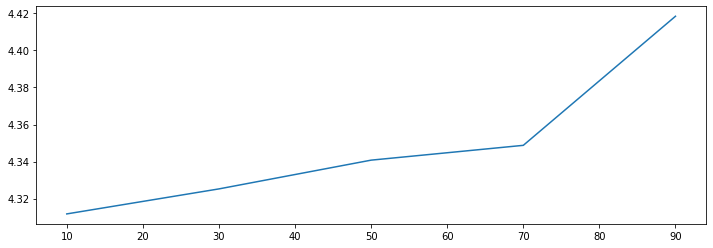

In [98]:
plt.plot(np.arange(10, 100, 20), losses)

What about K less than 10?

In [100]:
AAAA = []
BBBB = []

In [ ]:
for p in [1, 3, 5, 7, 9]:
    AAA = []
    BBB = []
    for k in range(10):
      K = p
      W = np.random.randn(10000, K)
      P = np.zeros(10000)
      U = np.random.randn(10000, K)
      Q = np.zeros(10000)
      mu = np.mean(list(to_rating.values()))
      epochs = 3
      reg = 100
      train_losses = []
      val_losses = []
      train_losses.append(get_loss(to_rating))
      val_losses.append(get_loss(to_rating_val))
      stop = 0
      for epoch in range(epochs):
          print("epoch:", epoch)
          epoch_start = datetime.now()
          
          t0 = datetime.now()
          for i in user_to_channel.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              pi = 0
              for j in user_to_channel[i]:
                  r = to_rating[(i, j)]
                  matrix += np.outer(U[j], U[j])
                  vector += (r - P[i] - Q[i] - mu) * U[j]
                  pi += (r - W[i].dot(U[j]) - Q[j] - mu)
              
              W[i] = np.linalg.solve(matrix, vector)
              P[i] = pi / (len(user_to_channel[i]) + reg)
          
          for j in channel_to_user.keys():
              matrix = np.eye(K) * reg
              vector = np.zeros(K)
              
              Qj = 0
              try:
                  for i in channel_to_user[j]:
                      r = to_rating[(i, j)]
                      matrix += np.outer(W[i], W[i])
                      vector += (r - P[i] - Q[j] - mu) * W[i]
                      Qj += (r - W[i].dot(U[j]) - P[i] - mu)
                  
                  U[j] = np.linalg.solve(matrix, vector)
                  Q[j] = Qj / (len(channel_to_user[j]) + reg)
                  
              except KeyError:
                  pass
          
          train_losses.append(get_loss(to_rating))
          val_losses.append(get_loss(to_rating_val))
          print("time spent:", datetime.now() - t0)
          print("train loss:", train_losses[-1])
          print("validation loss:", val_losses[-1])
          if val_losses[-1] > val_losses[-2]:
              stop += 1
          else:
              stop = 0
          if stop == 2:
              break
      AAA.append(train_losses[-1])
      BBB.append(val_losses[-1])
    AAAA.append(AAA)
    BBBB.append(BBB)

In [144]:
losses = [0, 0, 0, 0, 0]
for i in range(0, 5):
  DDDD = []
  for j in range(len(BBBB)//5):
    DDDD += BBBB[j*5 + i]
  losses[i] = np.array(DDDD).mean()

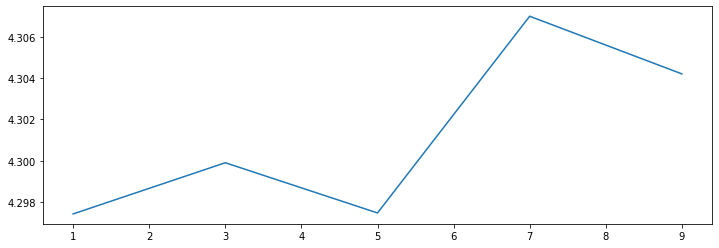

In [146]:
plt.plot(np.arange(1, 10, 2), losses)

The results indicate that a $K$ value from $1$ to $5$ is all ok. We will use $K = 5$ for the final evaluation. Now let's train the model one last time and apply the trained model to the testing set.

In [ ]:
K = 5
W = np.random.randn(10000, K)
b = np.zeros(10000)
U = np.random.randn(10000, K)
c = np.zeros(10000)
mu = np.mean(list(to_rating.values()))
epochs = 10
reg = 100
train_losses = []
val_losses = []
train_losses.append(get_loss(to_rating))
val_losses.append(get_loss(to_rating_val))
stop = 0
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.now()
    
    t0 = datetime.now()
    for i in user_to_channel.keys():
        matrix = np.eye(K) * reg
        vector = np.zeros(K)
        
        pi = 0
        for j in user_to_channel[i]:
            r = to_rating[(i, j)]
            matrix += np.outer(U[j], U[j])
            vector += (r - P[i] - Q[i] - mu) * U[j]
            pi += (r - W[i].dot(U[j]) - Q[j] - mu)
        
        W[i] = np.linalg.solve(matrix, vector)
        P[i] = pi / (len(user_to_channel[i]) + reg)
    
    for j in channel_to_user.keys():
        matrix = np.eye(K) * reg
        vector = np.zeros(K)
        
        Qj = 0
        try:
            for i in channel_to_user[j]:
                r = to_rating[(i, j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - P[i] - Q[j] - mu) * W[i]
                Qj += (r - W[i].dot(U[j]) - P[i] - mu)
            
            U[j] = np.linalg.solve(matrix, vector)
            Q[j] = Qj / (len(channel_to_user[j]) + reg)
            
        except KeyError:
            pass

    train_losses.append(get_loss(to_rating))
    val_losses.append(get_loss(to_rating_val))
    if val_losses[-1] > val_losses[-2]:
        stop += 1
    else:
        stop = 0
    if stop == 2:
        break
train_vs_reg.append(train_losses)
val_vs_reg.append(val_losses)

# **5. Evaluation**

First, evaluate the results we get from the user-user collaborative filtering.

In [19]:
def mse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.mean((a-b)**2)

train = pd.DataFrame([train_prediction, train_target])
train = np.transpose(train)
train.dropna(inplace = True)
train.rename(columns = {0: "predictions", 1: "target"}, inplace = True)

test = pd.DataFrame([test_prediction, test_target])
test = np.transpose(test)
test.dropna(inplace = True)
test.rename(columns = {0: "predictions", 1: "target"}, inplace = True)

print("Train mse: ", mse(train.predictions, train.target))
print("Test mse: ", mse(test.predictions, test.target))

Train mse:  2.0658060524441564
Test mse:  5.182405427276896


Secondly, evaluate the results we get from matrix factorization.

In [180]:
print("Train mse: ", get_loss(to_rating)[0])
print("Test mse: ", get_loss(to_rating_test)[0])

Train mse:  2.7134160902029993
Test mse:  3.5303203699061587


Due to the regularization, matrix factorization doesn't overfit as much as the user-user collaborative filtering. The difference between the test and train loss is smaller. 

At the same time, the performance of matrix factorization is around 33% better than user-user collaborative filtering. This machine learning has proven to perform really well.

# **6. Conclusion & Reflection**
Although the performance is pretty good, there is still enormous space for improvement.

To start with, the sample size used in this project is too small. We only take Reddit comment data for one day and subset them substantially. As a result, the tuned $K$ is really small, so there aren't many categories the program can learn from the existing data. Instead, the recommendation is mainly based on the bias of users ($P$), of channels ($Q$), and of their simple interactions ($W \times U^{T}$). If the entire Reddit data is available, then $W \times U^{T}$ would be much more complicated and help make better recommendations.

Also, we tune the parameters one by one. It would be better to have a 2-D grid to prevent local minimum. At the same time, cross-validations would help stabilize the training process by reducing the variance.

Finally, one crucial problem with matrix factorization is its applicability. Notice that all recommendations are made for existing users and channels. To recommend channels for new users, we need to increase the matrix sizes and train a new pair of $W$, $U$, $P$, and $Q$. Moreover, if we incorporate millions of users and channels, the computation time also increases exponentially. 

But with all that being said, the result of this project is decent. We implement a rudimentary matrix factorization recommendation model on Reddit data. It proves to be fairly effective on a small sample size.

